In [2]:
!pip install python-chess numpy pandas matplotlib keras ipython

In [8]:
import chess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Flatten
import chess.svg

In [16]:
def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    arr = np.zeros(len(pieces))
    
    if piece in piece_to_index:
        index = piece_to_index[piece]
        arr[index] = 1
    else:
        raise ValueError(f"Unexpected piece: {piece}")
    
    return arr

def encode_board(board):
    board_str = str(board)
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_piece(piece))
        board_list.append(row_list)
    return np.array(board_list).flatten()

In [17]:
input_shape = (64*13, ) # 64 vị trí, 13 loại trạng thái bao gồm 6 quân trắng, 6 quân đen và trạng thái trống "."
model = Sequential([
    Input(shape=input_shape),
    Flatten(),  
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

In [20]:
train_df = pd.read_csv('data/ChessData.csv')
train_df = train_df[:500000]

In [22]:
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['score']

Epoch 1/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 240041.7969 - val_loss: 142345.7031
Epoch 2/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 131607.1875 - val_loss: 118558.5547
Epoch 3/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 112835.5938 - val_loss: 102715.1953
Epoch 4/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 99783.6641 - val_loss: 93872.2188
Epoch 5/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 90569.1562 - val_loss: 95177.9453
Epoch 6/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 86087.7031 - val_loss: 86867.1250
Epoch 7/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 82477.7031 - val_loss: 83957.2656
Epoch 8/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 78851.4375 - val_loss: 82946.0547
Epoch 9/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 75750.4062 - val_loss: 81324.9062
Epoch 10/100
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 74719.3516 - val_loss: 80217.5781
Epoch 11/100
703

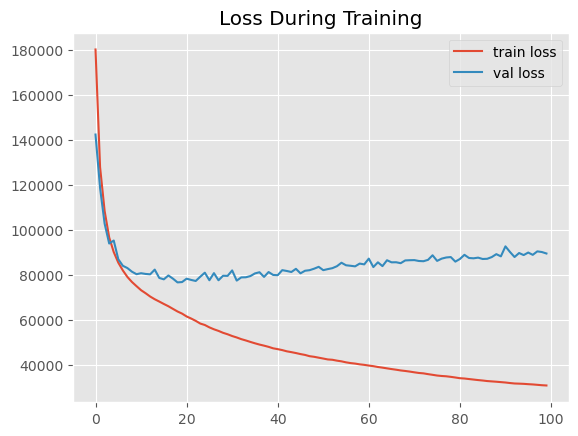

In [23]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1)

plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

In [1]:
def evaluate_board(board):
    encoded_board = encode_board(board)
    encoded_board = np.expand_dims(encoded_board, axis=0)
    score = model.predict(encoded_board, verbose=0)
    return score[0][0]

def minimax(board, depth, alpha, beta, maximizingPlayer):
    if depth == 0 or board.is_game_over():
        return evaluate_board(board)
    
    if maximizingPlayer:
        max_eval = -float('inf')
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = float('inf')
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval

def find_best_move(board, depth=3):
    best_move = None
    best_value = -float('inf')
    
    for move in board.legal_moves:
        board.push(move)
        board_value = minimax(board, depth - 1, -float('inf'), float('inf'), False)
        board.pop()
        
        if board_value > best_value:
            best_value = board_value
            best_move = move
            
    return best_move

def play_game():
    board = chess.Board()
    print(board)
    
    while not board.is_game_over():
        print()
        # Lượt của quân trắng (người chơi)
        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            if user_move not in [str(move) for move in board.legal_moves]:
                print('Invalid move. Try again.')
                continue
            board.push_san(user_move)
        else:
            # Lượt của quân đen (AI)
            ai_move = find_best_move(board, depth=2)
            print(f'AI move: {ai_move}')
            board.push(ai_move)
        print(board)
        
    print(board.outcome())

play_game()

NameError: name 'chess' is not defined